# Mod5 Project - IEEE-CIS Fraud Detection
## Kaggle competition

In this project, I am utilizing machine learning models on a challenging large-scale dataset to distinguish fraudulent card transaction from dataset from Vesta's real-world e-commerce transactions. The goal is to predict the probability of online transaction is fraudulent, as marked by binary target isFraud.

Competition link: https://www.kaggle.com/c/ieee-fraud-detection/


### Data Mining

I will import the data file and start mining process here

In [1]:
# Importing required libraries for the job
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn import preprocessing, metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import numpy as np
import pandas as pd
import gc, datetime, random
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold



In [2]:
# This function will geenerate some random numbers

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(SEED)

In [3]:
pd.set_option('display.max_columns', 500) # Changing Max display columns to 500

Dataset is consist of two datasets: Information about the identity of the customer and transaction information.

In [4]:
# Reading data & checking the shape


train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
sub = pd.read_csv('sample_submission.csv')


# Combining dataframe to be easier data handling
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
print(train.shape)
print(test.shape)

(590540, 434)
(506691, 433)


In [5]:
# No need to keep original dataframes
del train_identity ,train_transaction ,test_identity ,test_transaction

In [6]:
# Checking to see what's in train set
train.head(-10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.000000,0.0,0.0,0.000000,0.0,0.0,117.000000,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,117.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,credit,325

In [7]:
# Checking test set as well
test.head(-10)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.950,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000,W,4272,111.0,150.0,v

In [8]:
# Checking data columns

list(train.columns)

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V

In [9]:
train.columns.nunique()

434

Dataset contains whopping 434 columns.

### Data Exploration


My goal for Data Exploration:
- What type of data do I have:
- How many missing values?
- Is data imbalanced?
- Is there obvious signs for fraudulent transactions?
- Finding Interesting patterns

#### Checking null values

First thing to do is always looking for NANs and Null values.

In [10]:
# Checking null values

null = train.isnull().sum()/len(train) * 100
null = data_null.drop(data_null[null == 0].index).sort_values(ascending=False)
missing = pd.DataFrame({'Missing Ratio': null})
missing.head(40)

NameError: name 'data_null' is not defined

In [ ]:
# Plotting graphs for missing rate for each columns

plt.subplots(figsize=(70,10))
plt.xticks(rotation='90')
sns.barplot(null.index, null)
plt.xlabel('Features', fontsize=5)
plt.ylabel('Missing Data rate', fontsize=5)
plt.title('Missing Rates for Columns')

There're many columns with more tha 90% of missing values or NANs. These columns will be dropped later on.

#### From Kaggle discussion board, https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203

Transaction Table
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and R__ emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Identity Table
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9


The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

### TransactionDT

TransactionDT cloumn has time information.

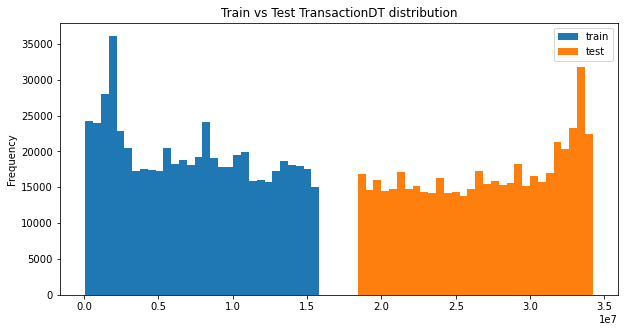

In [8]:
# Plotting for TransactionDT

train['TransactionDT'].plot(kind='hist',
                                        figsize=(10, 5),
                                        label='train',
                                        bins=30,
                                        title='Train vs Test TransactionDT distribution')
test['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=30)ds
plt.legend()
plt.show()

In [22]:
# 2nd processing for date
START_DATE = '2017-12-01'

startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
DateTime = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

DateTime.head()

0   2017-12-02 00:00:00
1   2017-12-02 00:00:01
2   2017-12-02 00:01:09
3   2017-12-02 00:01:39
4   2017-12-02 00:01:46
Name: TransactionDT, dtype: datetime64[ns]

Train and test set doesn't overlap at all

### isFraud

Let's take a look at isFraud column

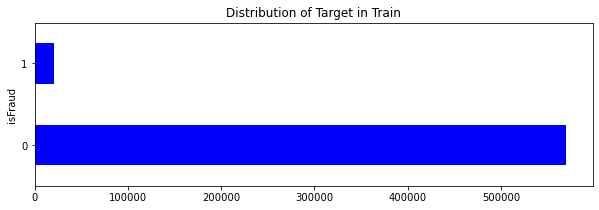

In [9]:
# Plotting counts for isFraud

train.groupby('isFraud').count()['TransactionID'].plot(kind='barh',
                                                       title='Distribution of Target in Train',
                                                       figsize=(10, 3), 
                                                       color = 'b')
plt.show()

In [10]:
perc = len(train.loc[train.isFraud == 1])/len(train.isFraud)*100
print('isFraud percent = ',perc , '%')

isFraud percent =  3.4990009144173126 %


Data is imbalanced. I must have to compensate it out with under/oversampling method later.

### TransactionAmt

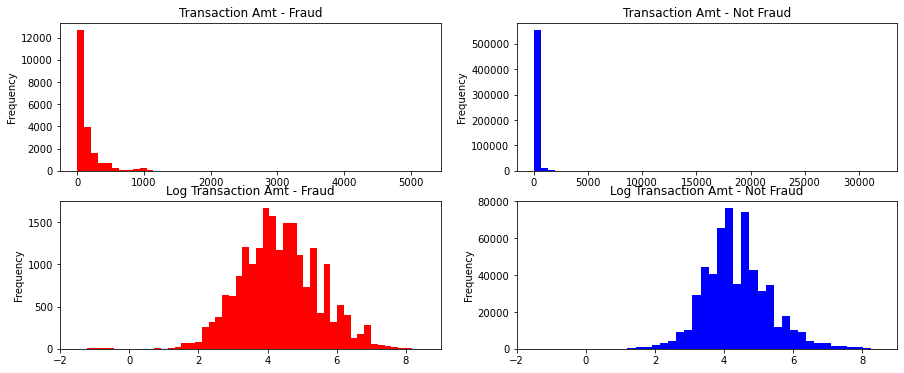

In [10]:
# Taking a look at distribution of TransactionAmt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))

train.loc[train_transaction['isFraud'] == 1] \
['TransactionAmt'].plot(kind='hist',
          bins=50,
          title='Transaction Amt - Fraud',
          color='r',
          ax= ax1)
train.loc[train_transaction['isFraud'] == 0] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=50,
          color='b',
          title='Transaction Amt - Not Fraud',
          ax=ax2)

train.loc[train_transaction['isFraud'] == 1] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=50,
          color='r',
          title='Log Transaction Amt - Fraud',
          xlim=(-2, 9),
         ax= ax3)
train.loc[train_transaction['isFraud'] == 0] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=50,
          color='b',
          title='Log Transaction Amt - Not Fraud',
         xlim=(-2,9),
         ax=ax4)


plt.show()

Transaction amount definitely needs to be normalized.

### ProductCD

ProductCD: product code, the product for each transaction

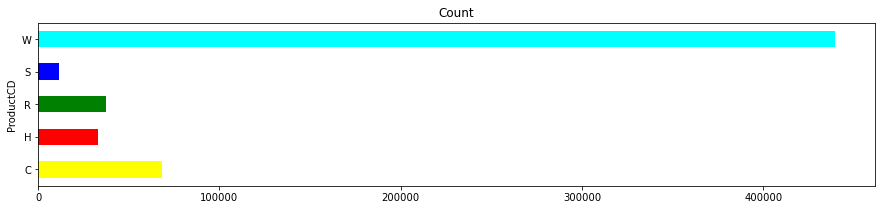

In [16]:
# Plotting for ProductCD type counts

train.groupby('ProductCD')['TransactionID'].count().sort_index().plot(kind='barh', 
                                                                      figsize=(15,3), 
                                                                      color=['yellow', 'red', 'green', 'blue', 'cyan'],
                                                                      title='Count')
plt.show()

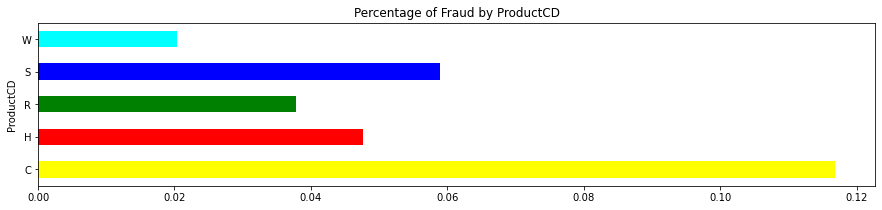

In [17]:
# Fraud counts per product

train.groupby('ProductCD')['isFraud'].mean().sort_index().plot(kind='barh',
                                                               figsize=(15, 3), 
                                                               color=['yellow', 'red', 'green', 'blue', 'cyan'],
                                                                 title='Percentage of Fraud by ProductCD')
plt.show()

### Card1 - Card 6

card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

In [19]:
# Setting up card columns for callout for graph

card_cols = [i for i in train.columns if 'card' in i]
train[card_cols].head()


,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


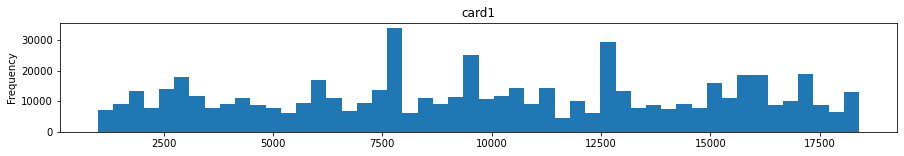

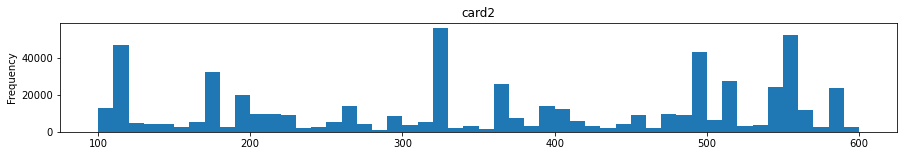

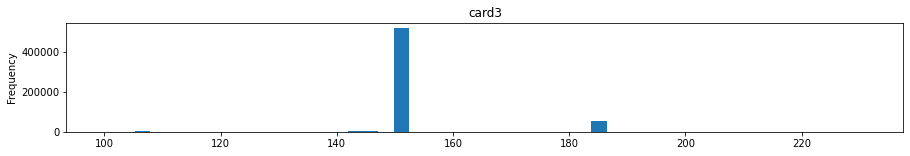

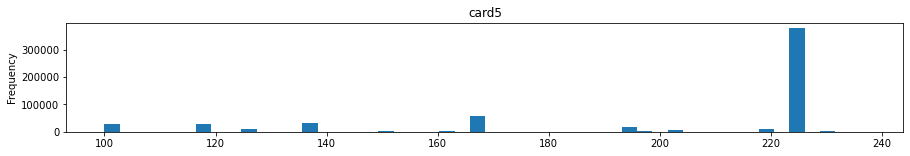

In [21]:
# Plotting frequency for each cards for amount

for i in card_cols:
    if train_transaction[i].dtype in ['float64','int64']:
        train_transaction[i].plot(kind='hist',
                                      title=i,
                                      bins=50,
                                      figsize=(15, 2)
                                      )
    
    plt.show()

Some obvious values for card 3 and 5

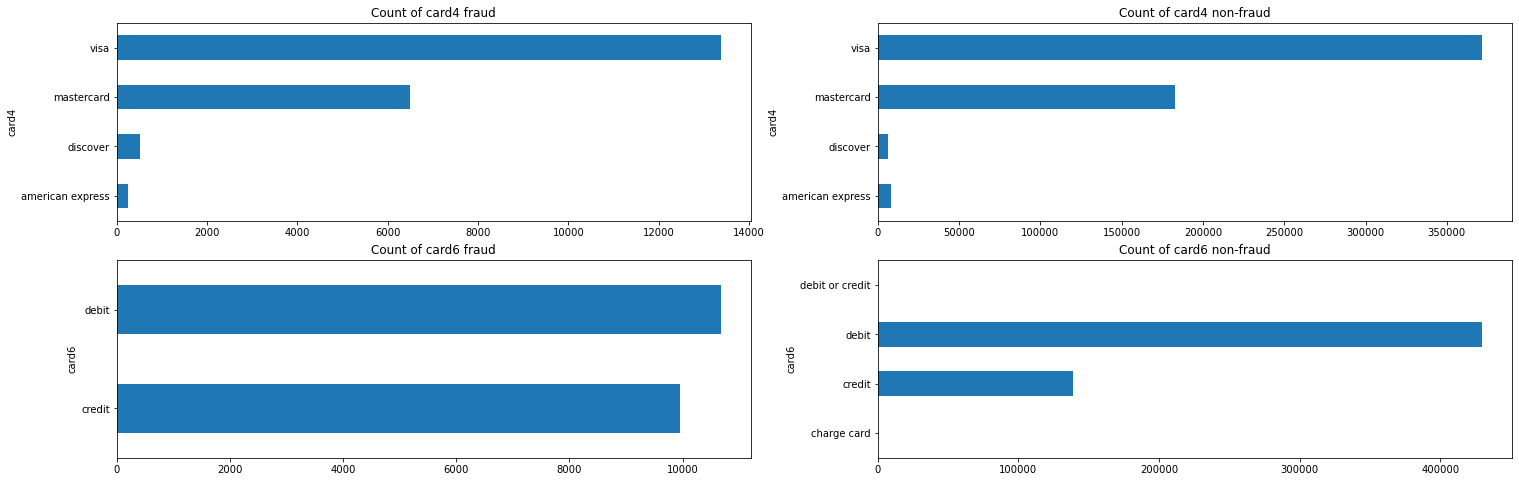

In [46]:
# Fraud copunts per card type, and credit/debit suage

train_fr = train.loc[train['isFraud'] == 1]
train_nofr = train.loc[train['isFraud'] == 0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 8))
train_fr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax1, title='Count of card4 fraud')
train_nofr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax2, title='Count of card4 non-fraud')
train_fr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax3, title='Count of card6 fraud')
train_nofr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax4, title='Count of card6 non-fraud')
plt.show()

Visa and debit card was the most used card for the fraud.

### addr1 & addr 2

Addr1 & addr 2 is adresses

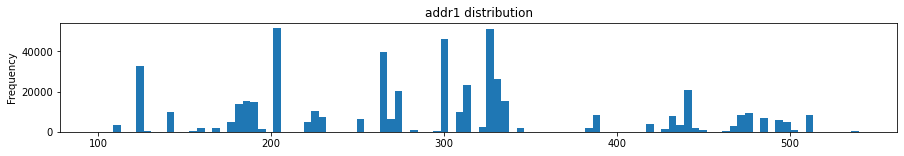

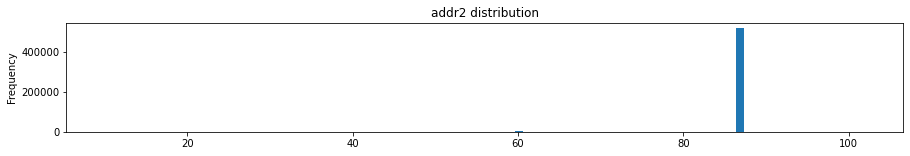

In [23]:
# Plotting addr1&2

train['addr1'].plot(kind='hist', bins=100, figsize=(15, 2), title='addr1 distribution')
plt.show()
train['addr2'].plot(kind='hist', bins=100, figsize=(15, 2), title='addr2 distribution')
plt.show()

Almost all entires in Addr2 are in one value. That's strange.

### dist1 & dist2

It's distance column

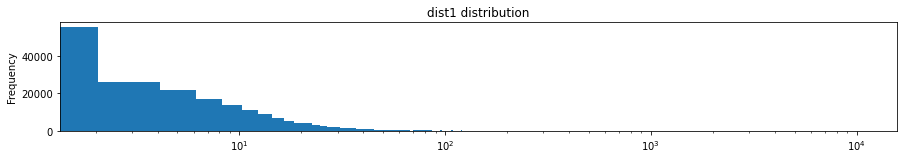

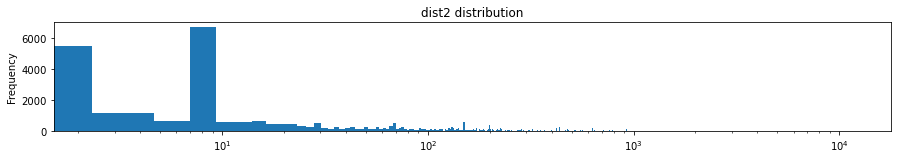

In [24]:
# Plotting dist1&2


train['dist1'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist1 distribution',
                                logx=True)
plt.show()
train['dist2'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist2 distribution',
                               logx=True)
plt.show()

it's very right skewed model.

### C1-C14

C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

In [10]:
# Setting up C columns call out

c_cols = [c for c in train if c[0] == 'C']
train[c_cols].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215
std,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,1.000000
75%,3.000000,3.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,12.000000,2.000000
max,4685.000000,5691.000000,26.000000,2253.000000,349.000000,2253.000000,2255.000000,3331.000000,210.000000,3257.000000,3188.000000,3188.000000,2918.000000,1429.000000


It's either 0,1 or extream values for most of the C columns

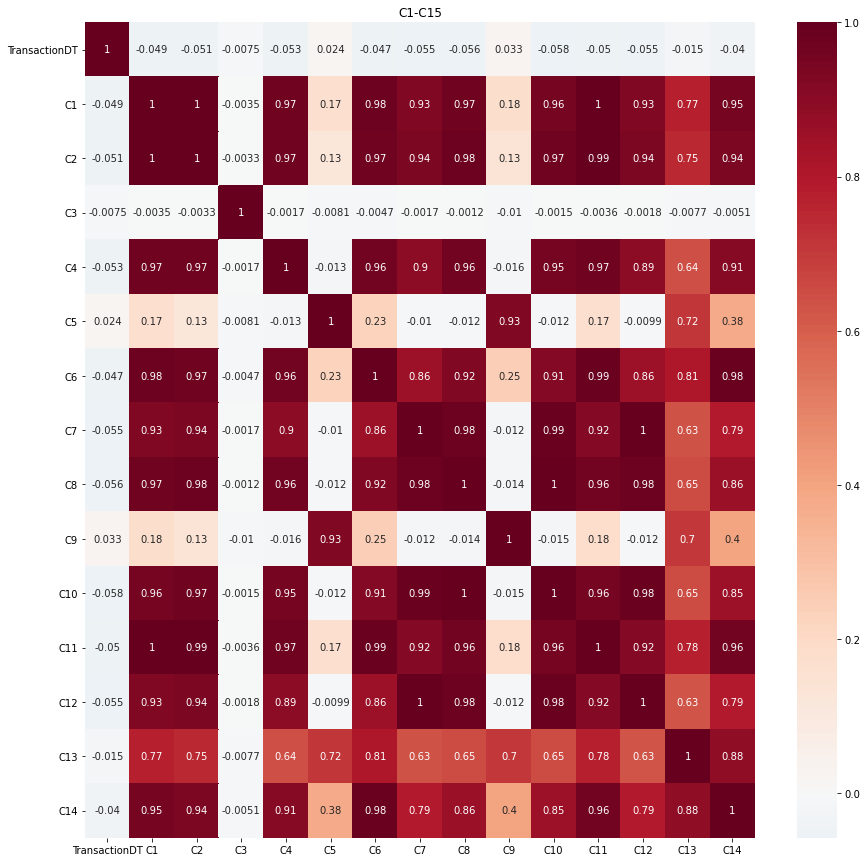

In [11]:
# Heat map for C columns

cols = ['TransactionDT'] + c_cols
plt.figure(figsize=(15,15))
sns.heatmap(train[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('C1-C15')
plt.show()

C columns look like highly correlated.

### D1-D9

D1-D15: timedelta, such as days between previous transaction, etc.

In [27]:
# Setting up D columns call out

D_cols = [d for d in train if d[0] == 'D']
train[D_cols].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,DeviceType,DeviceInfo
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,NaN,NaN
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,NaN,NaN
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mobile,SAMSUNG SM-G892A Build/NRD90M


In [28]:
train[D_cols].describe()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
count,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000
mean,94.347568,169.563231,28.343348,140.002441,42.335965,69.805717,41.638950,146.058108,0.561057,123.982137,146.621465,54.037533,17.901295,57.724444,163.744579
std,157.660387,177.315865,62.384721,191.096774,89.000144,143.669253,99.743264,231.663840,0.316880,182.615225,186.042622,124.274558,67.614425,136.312450,202.726660
min,0.000000,0.000000,0.000000,-122.000000,0.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,-83.000000,0.000000,-193.000000,-83.000000
25%,0.000000,26.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.958333,0.208333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,97.000000,8.000000,26.000000,10.000000,0.000000,0.000000,37.875000,0.666666,15.000000,43.000000,0.000000,0.000000,0.000000,52.000000
75%,122.000000,276.000000,27.000000,253.000000,32.000000,40.000000,17.000000,187.958328,0.833333,197.000000,274.000000,13.000000,0.000000,2.000000,314.000000
max,640.000000,640.000000,819.000000,869.000000,819.000000,873.000000,843.000000,1707.791626,0.958333,876.000000,670.000000,648.000000,847.000000,878.000000,879.000000


### M1-M9

M1-M9: match, such as names on card and address, etc.

In [30]:
# Call outs for M column

m_cols = [c for c in train if c[0] == 'M']
train[m_cols].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


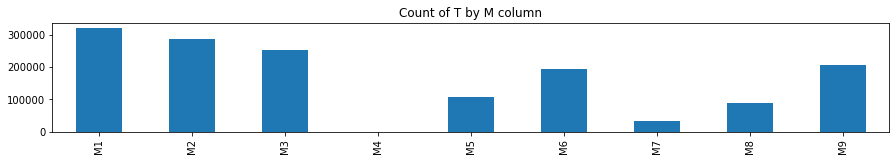

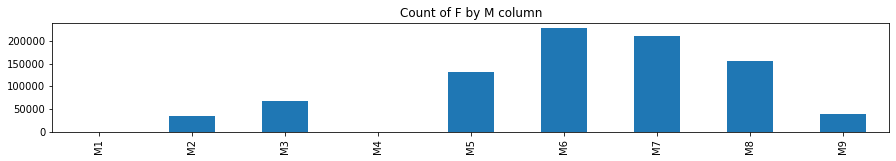

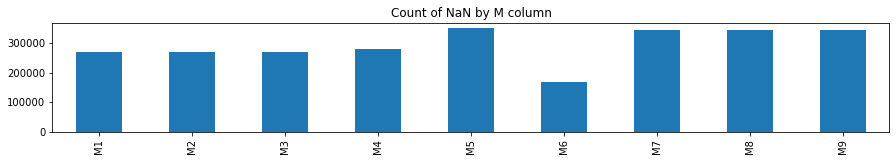

In [31]:
# Plotting for matching and unmatching for M columns

(train[m_cols] == 'T').sum().plot(kind='bar', title='Count of T by M column', figsize=(15, 2))
plt.show()

(train[m_cols] == 'F').sum().plot(kind='bar', title='Count of F by M column', figsize=(15, 2))
plt.show()

(train[m_cols].isna()).sum().plot(kind='bar', title='Count of NaN by M column',figsize=(15, 2))
plt.show()

### V1 - V339

V#s: Vesta engineered rich features, including ranking, counting, and other entity relations

In [33]:
# Callouts for V column

v_cols = [c for c in train if c[0] == 'V']
train[v_cols].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [34]:
train[v_cols].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,421571.000000,421571.000000,421571.000000,421571.00000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,590226.000000,590226.00000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,81945.000000,81945.000000,81945.000000,81945.000000,81945.000000,81951.000000,81951.000000,81951.000000,81945.000000,81945.000000,81945.000000,81945.000000,81951.000000,81951.000000,81951.000000,81945.000000,81945.000000,81945.000000,81945.000000,81945.000000,81945.000000,81951.000000,81951.000000,81945.000000,81945.000000,81945.000000,81951.000000,81951.000000,81951.000000,139631.000000,139631.000000,139819.000000,139819.000000,139819.000000,139631.000000,139631.000000,139819.000000,1

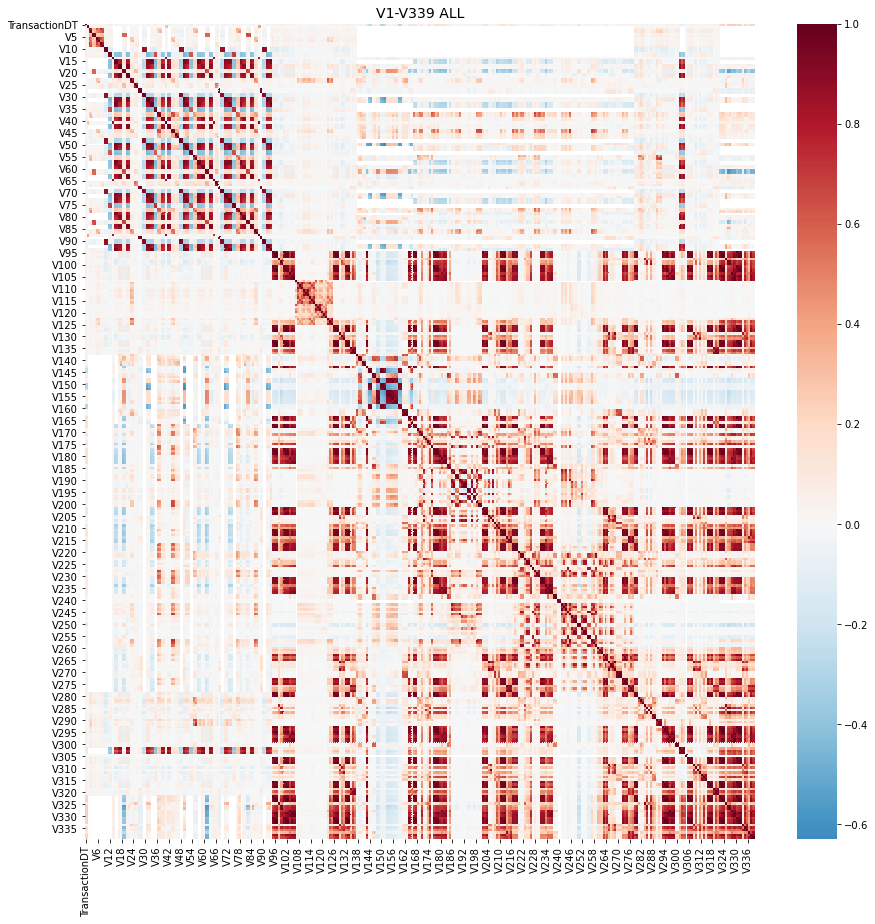

In [36]:
cols = ['TransactionDT'] + ['V'+str(x) for x in range(1,340)]
train2 = train[cols].sample(frac=0.2)
plt.figure(figsize=(15,15))
sns.heatmap(train2[cols].corr(), cmap='RdBu_r', annot=False, center=0.0)
plt.title('V1-V339 ALL',fontsize=14)
plt.show()

There're so many V columns and some of them are highly corelated.

### DeviceType & DeviceInfo

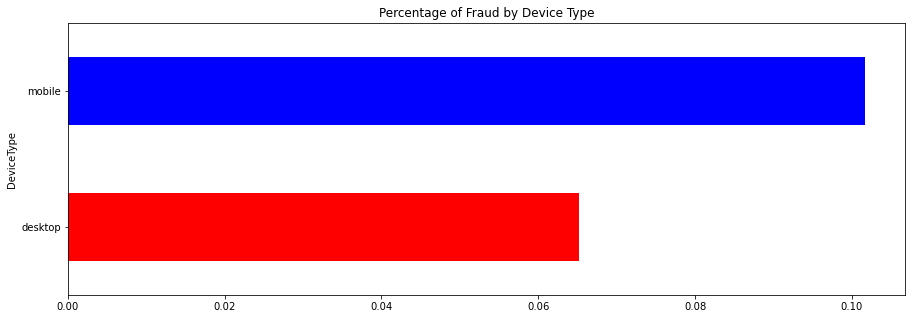

In [38]:
# Plot for mobile vs desktop

train.groupby('DeviceType').mean()['isFraud'].sort_values().plot(kind='barh',
          figsize=(15, 5),
          title='Percentage of Fraud by Device Type',
          color =['red','blue'])
plt.show()

In [26]:
# Counting for unique values

train.DeviceInfo.value_counts()

Windows        47722
iOS Device     19782
MacOS          12573
Trident/7.0     7440
rv:11.0         1901
               ...  
GT-I9195I          1
SM-G9250           1
XT1072             1
SM-T330            1
rv:29.0            1
Name: DeviceInfo, Length: 1786, dtype: int64

In [14]:
# More detailed description

train.P_emaildomain.describe()

count        496084
unique           59
top       gmail.com
freq         228355
Name: P_emaildomain, dtype: object

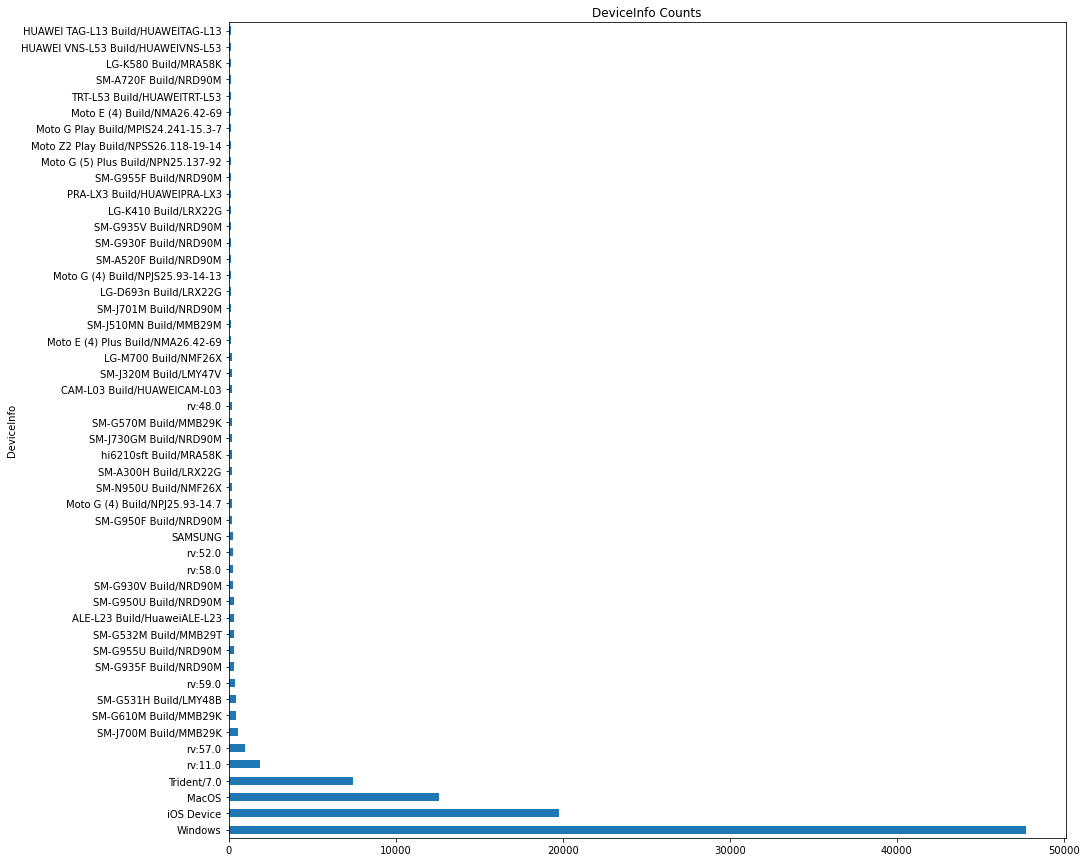

In [29]:
# Plot for deviceiInfo counts

train.groupby('DeviceInfo').count()['TransactionID'].sort_values(ascending=False).head(50) \
    .plot(kind='barh', figsize=(15, 15), title='DeviceInfo Counts')
plt.show()

1786 different kinds of devices were used.

### ID1 - ID32

Some of Id columns are categorical

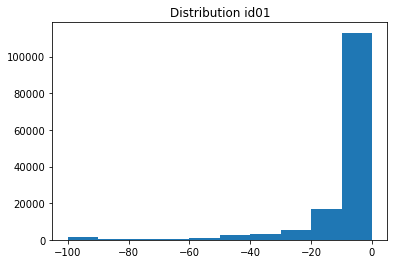

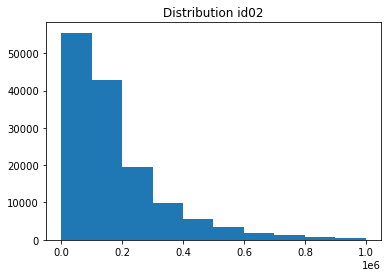

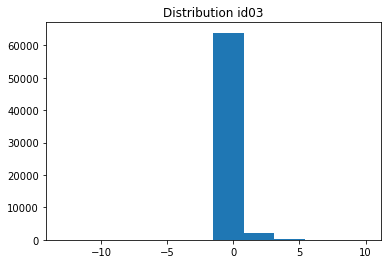

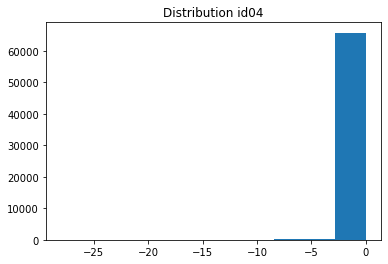

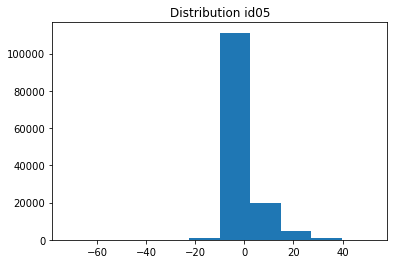

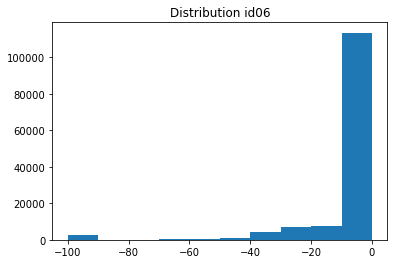

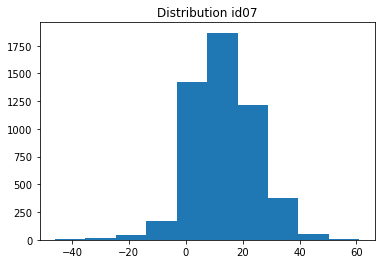

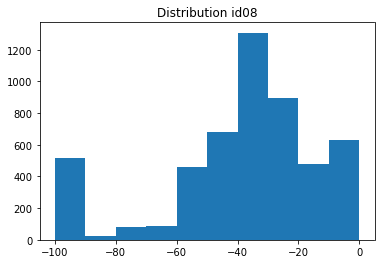

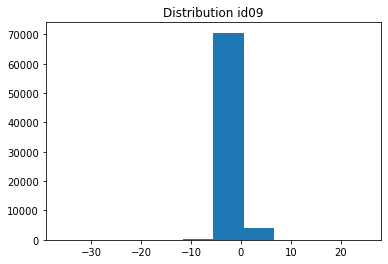

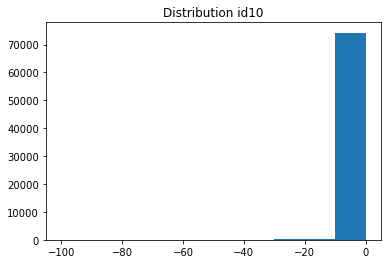

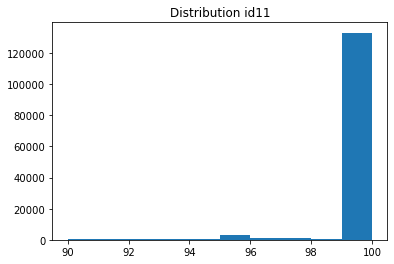

In [5]:
# Distribution plot for numerical Id columns

for i in range(1, 10):
    plt.hist(train['id_0' + str(i)])
    plt.title('Distribution id0' +str(i))
    plt.show()
    
for i in range(10, 12):
    plt.hist(train['id_' + str(i)])
    plt.title('Distribution id' +str(i))
    plt.show()

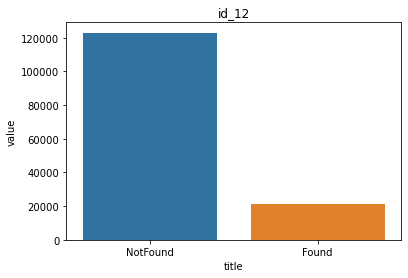

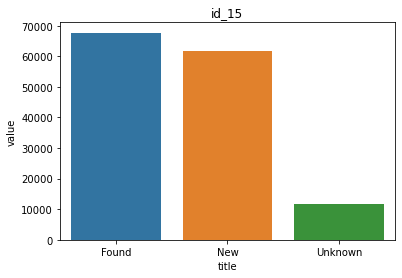

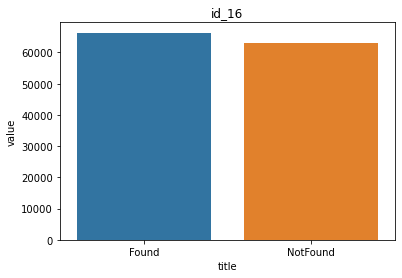

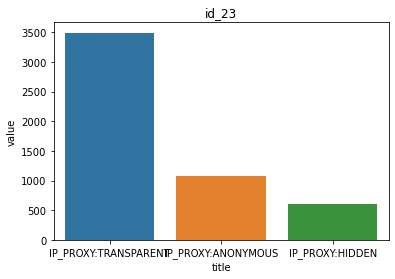

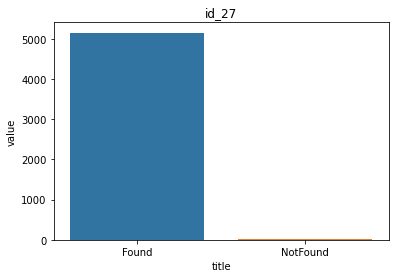

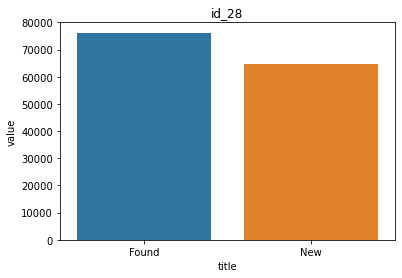

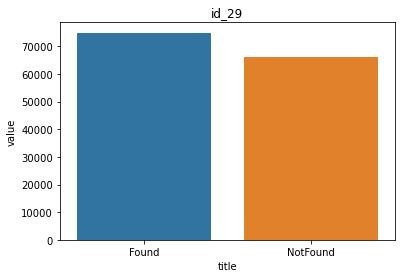

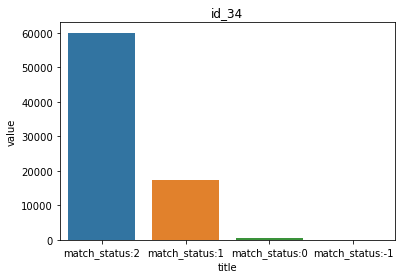

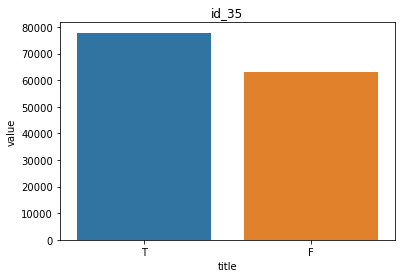

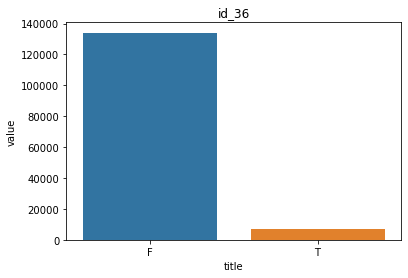

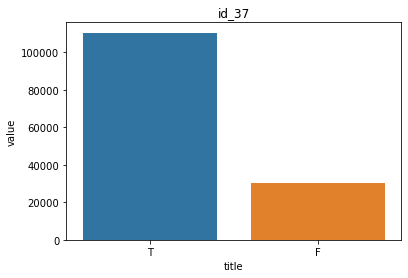

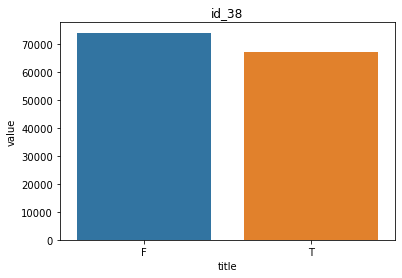

In [6]:
# Plots for categorical ID column

for i in ['id_12', 'id_15', 'id_16', 'id_23','id_27',
          'id_28', 'id_29', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']:
    df=train[i].value_counts(dropna=False).reset_index().rename(columns={'index':'title',i:'value'})
    sns.barplot(x='title', y='value', data=df).set_title(i)
    plt.show()

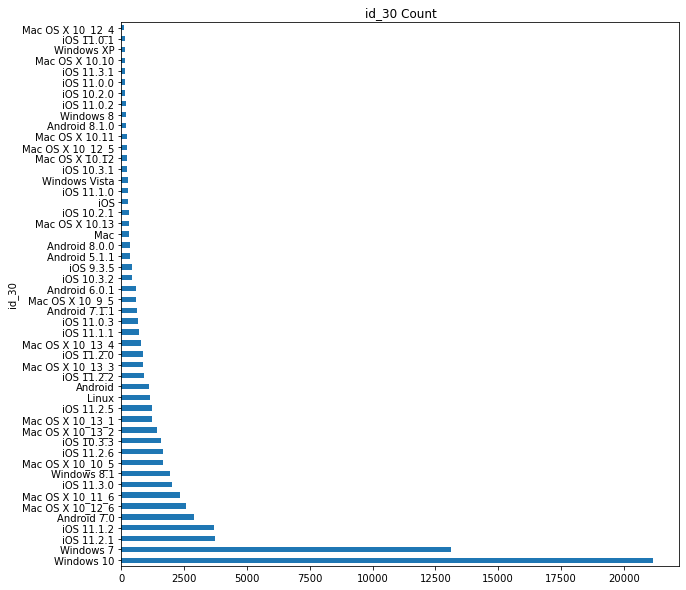

In [50]:
# Plot for id_30

train.groupby('id_30').count()['TransactionID'].sort_values(ascending=False).head(50) \
    .plot(kind='barh', figsize=(10, 10), title= 'id_30 Count')
plt.show()

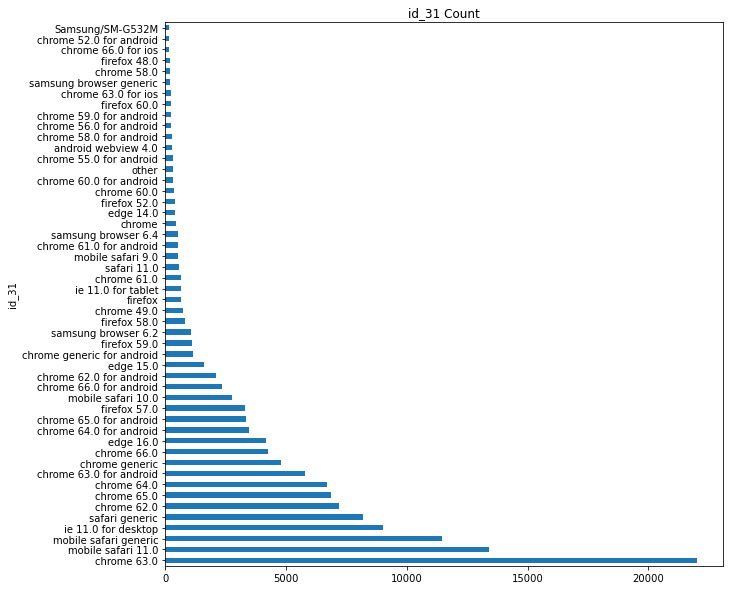

In [51]:
# Plot for id_31

train.groupby('id_31').count()['TransactionID'].sort_values(ascending=False).head(50) \
    .plot(kind='barh', figsize=(10, 10), title='id_31 Count')
plt.show()

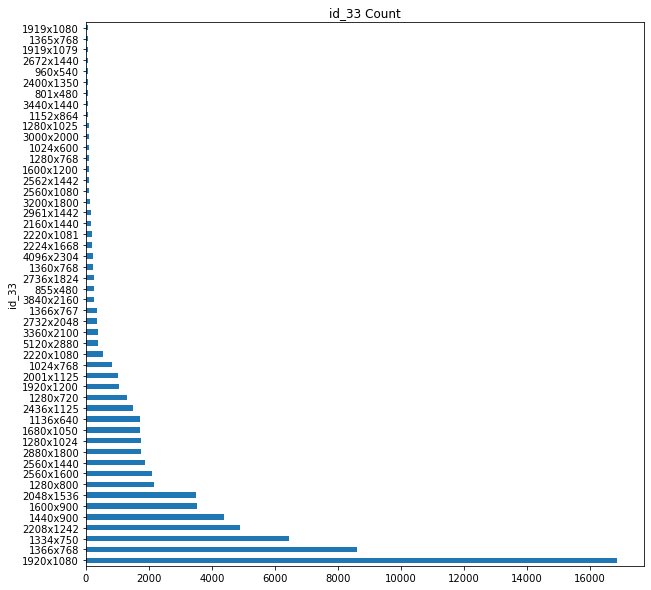

In [52]:
# Plot for id_33

train.groupby('id_33').count()['TransactionID'].sort_values(ascending=False).head(50) \
    .plot(kind='barh', figsize=(10, 10), title='id_33 Count')
plt.show()

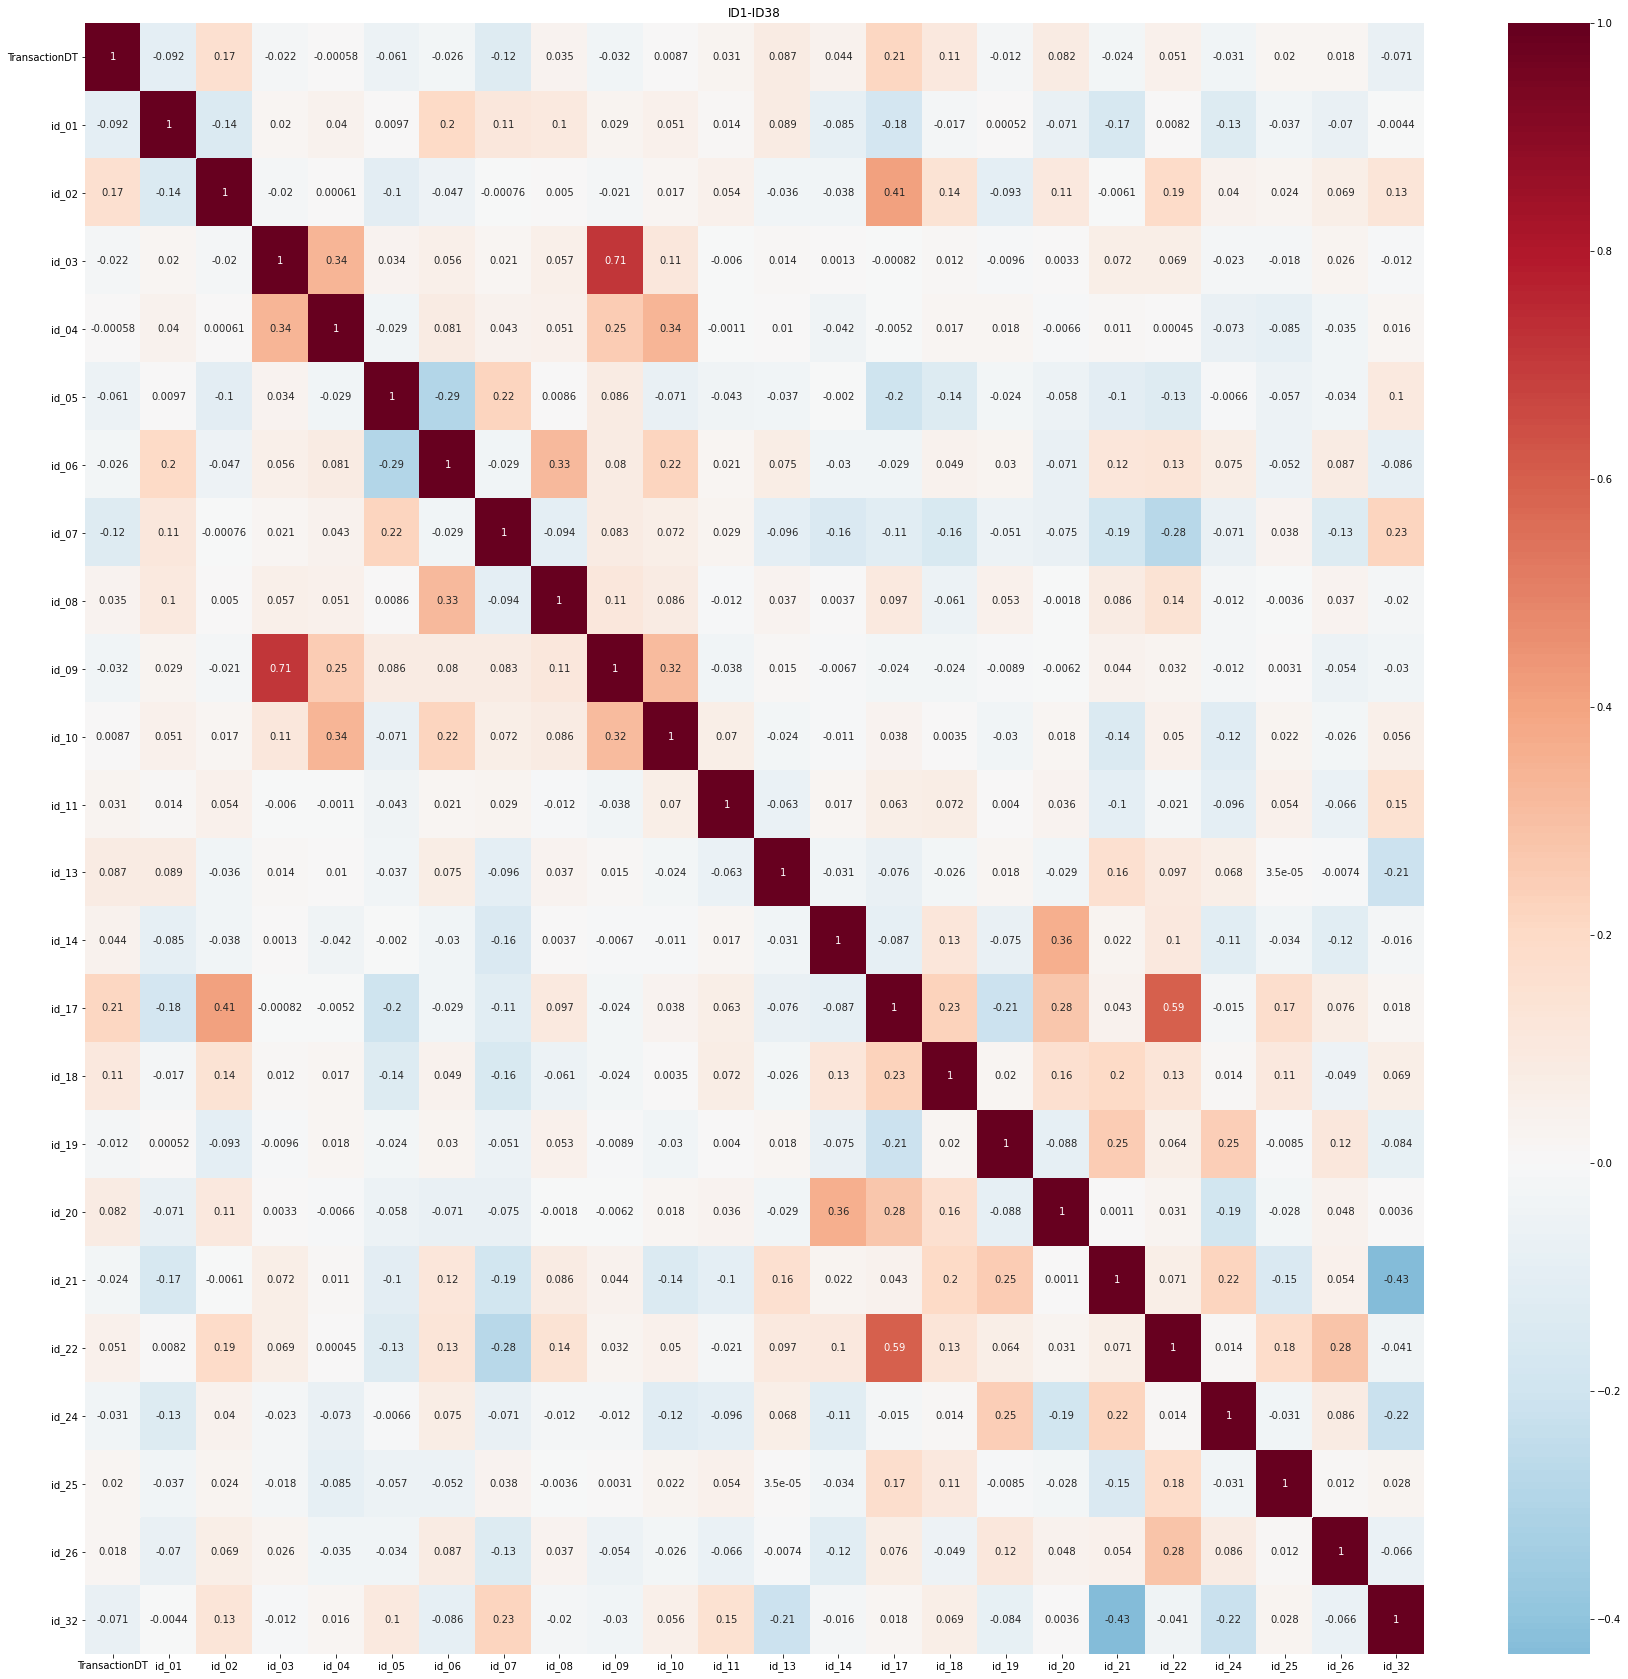

In [7]:
# Heat map for id colums

ids = ['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,39)]
cats = ['id_23','id_30','id_31','id_33','id_34']
cols = ['TransactionDT'] + [x for x in ids if x not in cats]
plt.figure(figsize=(30,30))
sns.heatmap(train[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('ID1-ID38')
plt.show()

Some of the ID columns were correlated.

### P_emaildomain & R_emaildomain

P_ and R_emaildomain: purchaser and recipient email domain

In [8]:
train.P_emaildomain.describe()

count        496084
unique           59
top       gmail.com
freq         228355
Name: P_emaildomain, dtype: object

In [11]:
train.P_emaildomain.value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
windstream.net         305
roadrunner.com         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com            230
t

In [13]:
train.R_emaildomain.value_counts()

gmail.com           57147
hotmail.com         27509
anonymous.com       20529
yahoo.com           11842
aol.com              3701
outlook.com          2507
comcast.net          1812
yahoo.com.mx         1508
icloud.com           1398
msn.com               852
live.com              762
live.com.mx           754
verizon.net           620
me.com                556
sbcglobal.net         552
cox.net               459
outlook.es            433
att.net               430
bellsouth.net         422
hotmail.fr            293
hotmail.es            292
web.de                237
mac.com               218
prodigy.net.mx        207
ymail.com             207
optonline.net         187
gmx.de                147
yahoo.fr              137
charter.net           127
mail.com              122
hotmail.co.uk         105
gmail                  95
earthlink.net          79
yahoo.de               75
rocketmail.com         69
embarqmail.com         68
scranton.edu           63
yahoo.es               57
live.fr     

I see bunch of same email domains but different countries or naes for both P_emaildomain and R_emaildomain

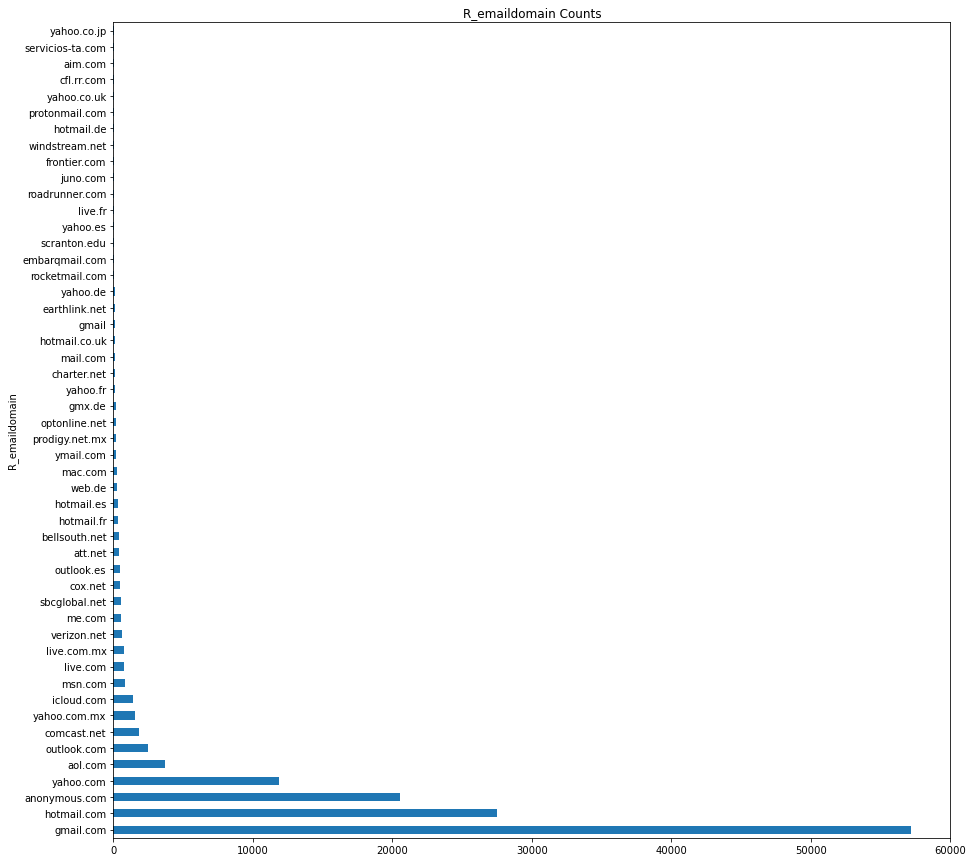

In [12]:
train.groupby('R_emaildomain').count()['TransactionID'].sort_values(ascending=False).head(50)\
.plot(kind='barh', figsize=(15, 15), title='R_emaildomain Counts')
plt.show()

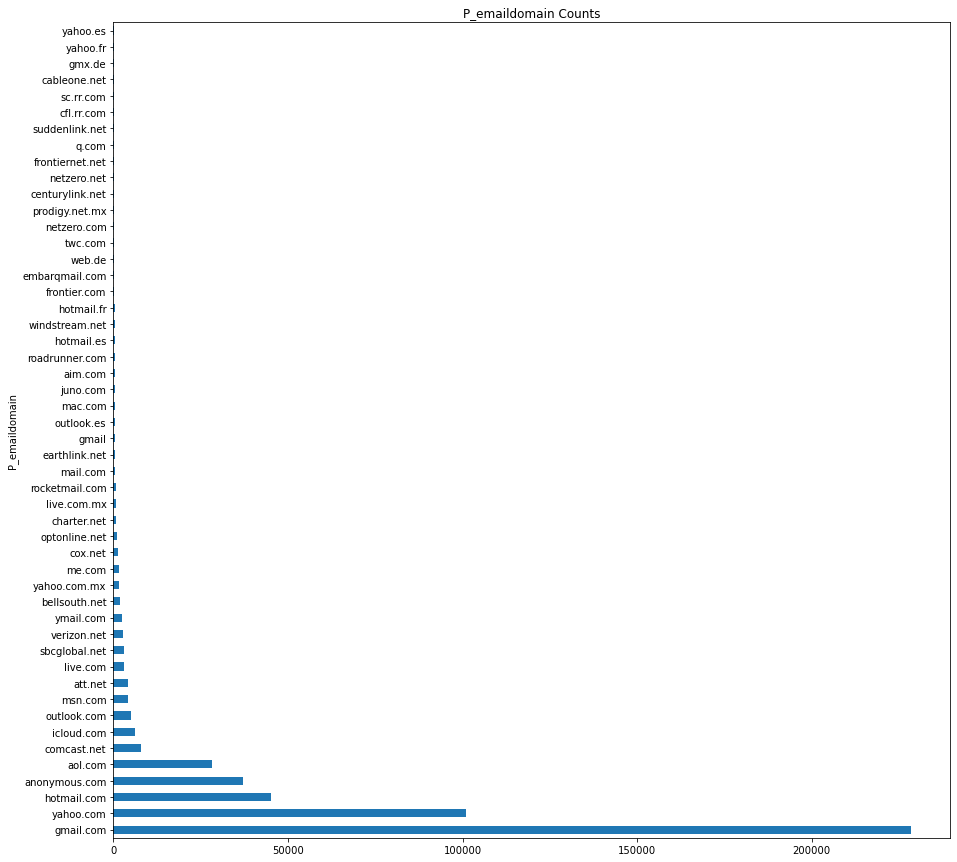

In [10]:
train.groupby('P_emaildomain').count()['TransactionID'].sort_values(ascending=False).head(50) \
    .plot(kind='barh', figsize=(15, 15), title='P_emaildomain Counts')
plt.show()

This concludes Data exploring. I could get some insights of what I'm dealing with. Since there'e so many data columns, I have to make sure to pick important ones to avoid curse of high demntion.

## Feature Engineering & Data prep for the Model

Feature engineering to reduce dimentionality and better data to train the model

#### User ID

Even though there're transactionID colum reresenting each transaction, there're multiple transactions from same card. This competition's goal is to predict fradulant card(customer). It's imortant to distinguish same card/customer.

- uid is addition of card1 , card2
- uid2 is card1, card2, card3 , card5
- uid3 is card1, card2, card3, card5, and addr1 and addr2

In [8]:
# Joining columns together to create new feature

def adduids(data): 
    data['uid'] = data['card1'].astype(str)+'_'+data['card2'].astype(str)

    data['uid2'] = data['uid'].astype(str)+'_'+data['card3'].astype(str)+'_'+data['card5'].astype(str)

    data['uid3'] = data['uid2'].astype(str)+'_'+data['addr1'].astype(str)+'_'+data['addr2'].astype(str)

     
    return data

train = adduids(train)
test = adduids(test)

There're 1786 different email domains in dataset. There are also bunch of same domain in different names. I will split in to prefixes and suffixes and perform binning of them.

In [9]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [10]:
# Check if purchaser and reciever email domain matches

p = 'P_emaildomain'
r = 'R_emaildomain'
uknown = 'email_not_provided'

def setDomain(df):
    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)
    
    
    df['email_check'] = np.where((df[p]==df[r])&(df[p]!=uknown),1,0)

    df[p+'_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r+'_prefix'] = df[r].apply(lambda x: x.split('.')[0])
    
    return df
    
train=setDomain(train)
test=setDomain(test)

In [11]:
test.head(-10)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,uid,uid2,uid3,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix,email_check,P_emaildomain_prefix,R_emaildomain_prefix
0,3663549,18403224,31.950,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,email_not_provided,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

Setting time for the dataset. I will use first date as 2017-12-01 and use delta tie to calculate datetime feature.

In [12]:
START_DATE = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')

def setTime(df):
    df['TransactionDT'] = df['TransactionDT'].fillna(df['TransactionDT'].median())
    
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    return df
    
train=setTime(train)
test=setTime(test)

C:\Users\Jun\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


We need to clean up some device names for better statistics.

In [13]:
# Aggregating device names

def setDevice(df):
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    #df['had_id'] = 1
    gc.collect()
    
    return df

train=setDevice(train)
test=setDevice(test)

#### Frequency encoding

Setting up frequency encoing for columns with integers.

In [14]:
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','device_name',
          'id_30','id_33',
          'uid','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc']  = test[col].map(fq_encode)


for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train[col+'_total'] = train[col].map(fq_encode)
    test[col+'_total']  = test[col].map(fq_encode)
        

periods = ['DT_M','DT_W','DT_D']
i_cols = ['uid']
for period in periods:
    for col in i_cols:
        new_column = col + '_' + period
            
        temp_df = pd.concat([train[[col,period]], test[[col,period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()
            
        train[new_column] = (train[col].astype(str) + '_' + train[period].astype(str)).map(fq_encode)
        test[new_column]  = (test[col].astype(str) + '_' + test[period].astype(str)).map(fq_encode)
        
        train[new_column] /= train[period+'_total']
        test[new_column]  /= test[period+'_total']

In [15]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,uid,uid2,uid3,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix,email_check,P_emaildomain_prefix,R_emaildomain_prefix,DT,DT_M,DT_W,DT_D,DT_hour,DT_day_week,DT_day,device_name,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C3_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D7_fq_enc,D8_fq_enc,addr1_fq_enc,addr2_fq_enc,dist1_fq_enc,dist2_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,DeviceInfo_fq_enc,device_name_fq_enc,id_30_fq_enc,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,uid3_fq_enc,DT_M_total,DT_W_total,DT_D_total,uid_DT_M,uid_DT_W,uid_DT_D
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,email_not_provided,email_not_provided,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Let's clean up missing data and NANs

In [16]:
# Functions to sort out colums with 90% or more missing values or 90% of same repeated values

def get_too_many_null_attr(data):
    many_null_cols = [col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.9]
    return many_null_cols

def get_too_many_repeated_val(data):
    big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return big_top_value_cols

def get_useless_columns(data):
    too_many_null = get_too_many_null_attr(data)
    print("More than 90% null: " + str(len(too_many_null)))
    too_many_repeated = get_too_many_repeated_val(data)
    print("More than 90% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(too_many_null + too_many_repeated))
    return cols_to_drop

In [17]:
# Calling out three function in onee

cols_to_drop = get_useless_columns(train)

More than 90% null: 12
More than 90% repeated value: 70


In [18]:
# Checking the list
cols_to_drop

['V298',
 'V117',
 'V116',
 'V311',
 'V296',
 'V98',
 'V295',
 'id_24',
 'V134',
 'V103',
 'V299',
 'isFraud',
 'id_22',
 'V101',
 'V122',
 'V121',
 'V284',
 'V316',
 'V132',
 'D7_fq_enc',
 'V286',
 'V290',
 'V137',
 'V305',
 'dist2_fq_enc',
 'id_25',
 'V133',
 'V129',
 'V309',
 'dist2',
 'V320',
 'V136',
 'V293',
 'D7',
 'V109',
 'id_18',
 'V114',
 'V301',
 'id_27',
 'V102',
 'V119',
 'V106',
 'V110',
 'C3_fq_enc',
 'V125',
 'V120',
 'V108',
 'id_07',
 'V107',
 'V319',
 'id_26',
 'C3',
 'V300',
 'V118',
 'V318',
 'V104',
 'V115',
 'id_23',
 'id_08',
 'V135',
 'id_21',
 'V111',
 'V321',
 'V124',
 'V123',
 'V113',
 'V281',
 'V297',
 'V112',
 'V105']

In [19]:
# Setting the list wihtout isFraud

cols_to_drop = ['id_23',
 'dist2',
 'V103',
 'V104',
 'V293',
 'V134',
 'id_26',
 'V113',
 'V110',
 'V133',
 'V296',
 'V290',
 'V124',
 'id_22',
 'V316',
 'id_27',
 'id_18',
 'V132',
 'V305',
 'V136',
 'V129',
 'V321',
 'id_07',
 'V117',
 'V295',
 'V114',
 'V116',
 'V320',
 'V298',
 'V319',
 'V122',
 'V106',
 'V115',
 'C3',
 'V135',
 'V281',
 'V297',
 'V137',
 'V107',
 'V311',
 'V108',
 'D7',
 'V300',
 'V125',
 'V105',
 'V309',
 'V111',
 'V101',
 'V102',
 'V112',
 'id_24',
 'V118',
 'V123',
 'id_08',
 'C3_fq_enc',
 'V98',
 'D7_fq_enc',
 'V109',
 'V301',
 'id_25',
 'V299',
 'dist2_fq_enc',
 'id_21',
 'V120',
 'V318',
 'V284',
 'V286',
 'V119',
 'V121']

Time to calculate highly correlated colums

In [20]:
# Function to cauclate highly correlated colums.

def correlation(dataset, threshold):
    col_corr = [] # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.append(colname)
                
    return(col_corr)

In [21]:
# 0.7 or higher for correlation setting

correlation = correlation(train, 0.7)

In [22]:
# Checking the list of highly correlated colums

correlation

['TransactionDT',
 'C2',
 'C4',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C13',
 'C14',
 'D2',
 'D5',
 'D6',
 'D7',
 'D12',
 'D15',
 'D15',
 'D15',
 'V3',
 'V5',
 'V7',
 'V8',
 'V11',
 'V13',
 'V15',
 'V16',
 'V18',
 'V20',
 'V21',
 'V22',
 'V24',
 'V26',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V33',
 'V34',
 'V34',
 'V36',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V45',
 'V47',
 'V48',
 'V49',
 'V50',
 'V50',
 'V51',
 'V51',
 'V52',
 'V54',
 'V57',
 'V57',
 'V58',
 'V58',
 'V59',
 'V60',
 'V62',
 'V63',
 'V64',
 'V65',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V71',
 'V72',
 'V73',
 'V73',
 'V74',
 'V75',
 'V75',
 'V76',
 'V78',
 'V79',
 'V79',
 'V80',
 'V81',
 'V82',
 'V84',
 'V85',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V92',
 'V93',
 'V94',
 'V94',
 'V96',
 'V97',
 'V100',
 'V101',
 'V102',
 'V103',
 'V105',
 'V105',
 'V106',
 'V106',
 'V110',
 'V110',
 'V112',
 'V113',
 'V114',
 'V116',
 'V119',
 'V119',
 'V122',
 'V125',
 'V125',
 

In [23]:
# Saving time for re-runs. No need to wait for calculation

correlation1 = ['TransactionDT',
 'C2',
 'C4',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C13',
 'C14',
 'D2',
 'D5',
 'D6',
 'D7',
 'D12',
 'D15',
 'D15',
 'D15',
 'V3',
 'V5',
 'V7',
 'V8',
 'V11',
 'V13',
 'V15',
 'V16',
 'V18',
 'V20',
 'V21',
 'V22',
 'V24',
 'V26',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V33',
 'V34',
 'V34',
 'V36',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V45',
 'V47',
 'V48',
 'V49',
 'V50',
 'V50',
 'V51',
 'V51',
 'V52',
 'V54',
 'V57',
 'V57',
 'V58',
 'V58',
 'V59',
 'V60',
 'V62',
 'V63',
 'V64',
 'V65',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V71',
 'V72',
 'V73',
 'V73',
 'V74',
 'V75',
 'V75',
 'V76',
 'V78',
 'V79',
 'V79',
 'V80',
 'V81',
 'V82',
 'V84',
 'V85',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V92',
 'V93',
 'V94',
 'V94',
 'V96',
 'V97',
 'V100',
 'V101',
 'V102',
 'V103',
 'V105',
 'V105',
 'V106',
 'V106',
 'V110',
 'V110',
 'V112',
 'V113',
 'V114',
 'V116',
 'V119',
 'V119',
 'V122',
 'V125',
 'V125',
 'V126',
 'V127',
 'V127',
 'V128',
 'V128',
 'V131',
 'V131',
 'V132',
 'V133',
 'V134',
 'V134',
 'V136',
 'V137',
 'V140',
 'V142',
 'V143',
 'V143',
 'V145',
 'V147',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V157',
 'V158',
 'V159',
 'V160',
 'V162',
 'V163',
 'V164',
 'V164',
 'V165',
 'V166',
 'V167',
 'V167',
 'V168',
 'V168',
 'V168',
 'V171',
 'V175',
 'V176',
 'V177',
 'V177',
 'V178',
 'V178',
 'V178',
 'V179',
 'V179',
 'V179',
 'V180',
 'V180',
 'V180',
 'V181',
 'V182',
 'V182',
 'V182',
 'V183',
 'V183',
 'V183',
 'V184',
 'V186',
 'V187',
 'V189',
 'V190',
 'V191',
 'V193',
 'V193',
 'V195',
 'V196',
 'V196',
 'V197',
 'V200',
 'V200',
 'V201',
 'V201',
 'V202',
 'V202',
 'V203',
 'V204',
 'V204',
 'V204',
 'V205',
 'V206',
 'V207',
 'V207',
 'V210',
 'V211',
 'V211',
 'V212',
 'V212',
 'V212',
 'V213',
 'V213',
 'V213',
 'V216',
 'V216',
 'V217',
 'V217',
 'V218',
 'V218',
 'V219',
 'V219',
 'V222',
 'V223',
 'V225',
 'V227',
 'V229',
 'V230',
 'V231',
 'V231',
 'V232',
 'V232',
 'V233',
 'V233',
 'V234',
 'V235',
 'V236',
 'V236',
 'V237',
 'V237',
 'V239',
 'V241',
 'V243',
 'V243',
 'V244',
 'V245',
 'V246',
 'V246',
 'V246',
 'V248',
 'V248',
 'V249',
 'V249',
 'V251',
 'V252',
 'V253',
 'V254',
 'V255',
 'V256',
 'V257',
 'V257',
 'V257',
 'V257',
 'V258',
 'V259',
 'V261',
 'V262',
 'V263',
 'V264',
 'V266',
 'V266',
 'V267',
 'V269',
 'V269',
 'V269',
 'V271',
 'V272',
 'V273',
 'V273',
 'V273',
 'V274',
 'V274',
 'V275',
 'V275',
 'V276',
 'V276',
 'V276',
 'V277',
 'V277',
 'V277',
 'V278',
 'V278',
 'V278',
 'V279',
 'V280',
 'V280',
 'V283',
 'V284',
 'V285',
 'V286',
 'V287',
 'V289',
 'V291',
 'V292',
 'V292',
 'V293',
 'V294',
 'V295',
 'V295',
 'V296',
 'V296',
 'V297',
 'V298',
 'V298',
 'V299',
 'V299',
 'V301',
 'V302',
 'V303',
 'V304',
 'V306',
 'V306',
 'V306',
 'V307',
 'V307',
 'V308',
 'V308',
 'V308',
 'V308',
 'V309',
 'V310',
 'V311',
 'V314',
 'V315',
 'V316',
 'V317',
 'V318',
 'V318',
 'V318',
 'V319',
 'V319',
 'V320',
 'V320',
 'V321',
 'V321',
 'V322',
 'V322',
 'V323',
 'V323',
 'V323',
 'V324',
 'V324',
 'V324',
 'V324',
 'V325',
 'V326',
 'V326',
 'V327',
 'V327',
 'V328',
 'V328',
 'V328',
 'V329',
 'V329',
 'V329',
 'V329',
 'V330',
 'V330',
 'V330',
 'V330',
 'V331',
 'V331',
 'V331',
 'V332',
 'V332',
 'V332',
 'V332',
 'V333',
 'V333',
 'V333',
 'V333',
 'V334',
 'V334',
 'V335',
 'V335',
 'V336',
 'V336',
 'V336',
 'V337',
 'V338',
 'id_09',
 'id_17',
 'email_check',
 'DT_M',
 'DT_W',
 'DT_D',
 'DT_hour',
 'card5_fq_enc',
 'C4_fq_enc',
 'C7_fq_enc',
 'C7_fq_enc',
 'C10_fq_enc',
 'C11_fq_enc',
 'C12_fq_enc',
 'C14_fq_enc',
 'D2_fq_enc',
 'D3_fq_enc',
 'D5_fq_enc',
 'D6_fq_enc',
 'addr2_fq_enc',
 'addr2_fq_enc',
 'R_emaildomain_fq_enc',
 'R_emaildomain_fq_enc',
 'DeviceInfo_fq_enc',
 'device_name_fq_enc',
 'id_30_fq_enc',
 'uid_fq_enc',
 'uid2_fq_enc',
 'DT_D_total',
 'uid_DT_M',
 'uid_DT_W']

In [24]:
# Combining two list together

for i in correlation:
    if i not in cols_to_drop:
        cols_to_drop.append(i)


In [25]:
# Chekcing final list
cols_to_drop

['id_23',
 'dist2',
 'V103',
 'V104',
 'V293',
 'V134',
 'id_26',
 'V113',
 'V110',
 'V133',
 'V296',
 'V290',
 'V124',
 'id_22',
 'V316',
 'id_27',
 'id_18',
 'V132',
 'V305',
 'V136',
 'V129',
 'V321',
 'id_07',
 'V117',
 'V295',
 'V114',
 'V116',
 'V320',
 'V298',
 'V319',
 'V122',
 'V106',
 'V115',
 'C3',
 'V135',
 'V281',
 'V297',
 'V137',
 'V107',
 'V311',
 'V108',
 'D7',
 'V300',
 'V125',
 'V105',
 'V309',
 'V111',
 'V101',
 'V102',
 'V112',
 'id_24',
 'V118',
 'V123',
 'id_08',
 'C3_fq_enc',
 'V98',
 'D7_fq_enc',
 'V109',
 'V301',
 'id_25',
 'V299',
 'dist2_fq_enc',
 'id_21',
 'V120',
 'V318',
 'V284',
 'V286',
 'V119',
 'V121',
 'TransactionDT',
 'C2',
 'C4',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D2',
 'D5',
 'D6',
 'D12',
 'D15',
 'V3',
 'V5',
 'V7',
 'V8',
 'V11',
 'V13',
 'V15',
 'V16',
 'V18',
 'V20',
 'V21',
 'V22',
 'V24',
 'V26',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V36',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43'

In [26]:
# Total number for the list

len(cols_to_drop)

331

In [28]:
# Seperating isFraud for modeling later
y = train['isFraud'].copy()
train = train.drop('isFraud', axis=1)

There're 331 colums to be dropped.

In [29]:
# Label Encoding for objects

for f in train.columns:
    if train[f].dtype.name =='object' or test[f].dtype.name =='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

Normalizing TransactionAmt column

In [30]:
# Log transform for TransactionAmt section

train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

In [31]:
train.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,uid,uid2,uid3,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix,email_check,P_emaildomain_prefix,R_emaildomain_prefix,DT,DT_M,DT_W,DT_D,DT_hour,DT_day_week,DT_day,device_name,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C3_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D7_fq_enc,D8_fq_enc,addr1_fq_enc,addr2_fq_enc,dist1_fq_enc,dist2_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,DeviceInfo_fq_enc,device_name_fq_enc,id_30_fq_enc,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,uid3_fq_enc,DT_M_total,DT_W_total,DT_D_total,uid_DT_M,uid_DT_W,uid_DT_D
0,2987000,86400,4.241327,4,13926,NaN,150.0,1,142.0,1,315.0,87.0,19.0,NaN,12,12,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [32]:
# Memory reduction for ram usage. It's straight from reference.

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [33]:
# Running the mem reduction function
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 639.21 Mb (71.4% reduction)
Mem. usage decreased to 555.22 Mb (71.1% reduction)


In [34]:
# Removing colums from dataset

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

Let's get rid of rest of NaNs with -999. Machine learning models will recognize this value as missing values.

In [35]:
# Replacing rest of the NaNs with -999. 

train = train.fillna(-999)
test = test.fillna(-999)

In [36]:
# Taking a quick look again
train.head()

,TransactionID,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C5,D1,D3,D4,D8,D9,D10,D11,D13,D14,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V4,V6,V9,V10,V12,V14,V17,V19,V23,V25,V27,V35,V37,V44,V46,V53,V55,V56,V61,V66,V77,V83,V86,V95,V99,V130,V138,V139,V141,V144,V146,V148,V161,V169,V170,V172,V173,V174,V185,V188,V192,V194,V198,V199,V208,V209,V214,V215,V220,V221,V224,V226,V228,V238,V240,V242,V247,V250,V260,V265,V268,V270,V282,V288,V312,V313,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,uid,uid2,uid3,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix,P_emaildomain_prefix,R_emaildomain_prefix,DT,DT_day_week,DT_day,device_name,card1_fq_enc,card2_fq_enc,card3_fq_enc,C1_fq_enc,C2_fq_enc,C5_fq_enc,C6_fq_enc,C8_fq_enc,C9_fq_enc,C13_fq_enc,D1_fq_enc,D4_fq_enc,D8_fq_enc,addr1_fq_enc,dist1_fq_enc,P_emaildomain_fq_enc,id_33_fq_enc,uid3_fq_enc,DT_M_total,DT_W_total,uid_DT_D
0,2987000,4.242188,4,13926,-999.0,150.0,1,142.0,1,315.0,87.0,19.0,12,12,1.0,0.0,14.0,13.0,-999.0,-999.0,-999.0,13.0,13.0,-999.0,-999.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,-999.0,-999.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2,-999.0,-999.0,3,2,-999.0,-999.0,2,2,86,136,-999.0,461,4,2,2,2,2,2,2564,4655,4765,14931,6,6,6,6,12,12,2017-12-02 00:00:00,5,2,25,56,17587,956845,586742,581696,707008,631237,816304,420354,367617,5548,245773,947967,43035,4707,163648,953271,2,134339,8852,0.000195
1,2987001,3.400391,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,-999.0,17,12,1.0,0.0,0.0,-999.0,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,2,2,2,0,1,1,2,2,2,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2,-999.0,-999.0,3,2,-999.0,-999.0,2,2,86,136,-999.0,461,4,2,2,2,2,2,2564,10937,11186,34958,4,0,6,6,16,12,2017-12-02 00:00:01,5,2,25,1338,5593,956845,586742,581696,707008,631237,816304,341561,367617,507854,344849,947967,76902,643488,435803,953271,105,134339,8852,0.001367
2,2987002,4.093750,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,287.0,36,12,1.0,0.0,0.0,-999.0,0.0,-999.0,-999.0,0.0,315.0,-999.0,-999.0,1,1,1,0,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2,-999.0,-999.0,3,2,-999.0,-999.0,2,2,86,136,-999.0,461,4,2,2,2,2,2,2564,13001,13293,41169,5,0,6,6,28,12,2017-12-02 00:01:09,5,2,25,1794,70496,956845,586742,581696,707008,631237,816304,420354,367617,507854,344849,947967,48387,38,9934,953271,46,134339,8852,0.001952
3,2987003,3.931641,4,18132,567.0,150.0,2,117.0,2,476.0,87.0,-999.0,55,12,2.0,0.0,112.0,0.0,94.0,-999.0,-999.0,84.0,-999.0,-999.0,-999.0,2,2,2,0,1,0,2,2,2,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,354.0,-999.0,-999.0

In [37]:
# Check to see if there's any Nans exsiting

print(train.isnull().sum().max())
print(test.isnull().sum().max())

0
0


In [38]:
# Dropping more unncessary colums

train =train.drop(columns=['DT', 'P_emaildomain','R_emaildomain'])
test = test.drop(columns=['DT', 'P_emaildomain','R_emaildomain'])

In [39]:
train2 = train

#### Performing PCA 

PCA will be performed on dataset to avoid to curse

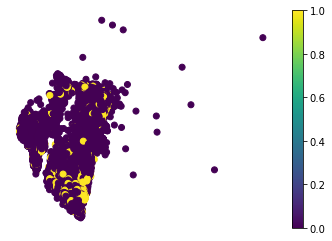

In [37]:
# PCA for overall

scaler = StandardScaler()
scaled = scaler.fit_transform(train)         
PCA_train_x = PCA(2).fit_transform(scaled)
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=y)
plt.axis('off')
plt.colorbar()
plt.show()

### Modeling

#### Light Gradient Boosting



In [40]:
# Setting up parameter for LGB modeling

params = {'min_child_weight': 0.03, # Higher values prevent overfitting
          'objective': 'binary',    # Classifying boolean
          'max_depth': 3,           # Controlling over-fitting typical values 3-10
          'learning_rate': 0.01,    # Low learning rate for better accuracy
          "boosting_type": "gbdt",  # Tree based model
          "metric": 'auc',          # Validation method
          "verbosity": 0,           # Prints messages 
         }

In [42]:
# Modeling and predicting

X_train = train
X_test = test
y_train = y




skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
columns = X_train.columns
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
score = 0
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns 
    
    
    
for fold_n, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
    
    X_tr, X_val = X_train[columns].iloc[train_index], X_train[columns].iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]    
    
    dtrain = lgb.Dataset(X_tr, label=y_tr)
    dvalid = lgb.Dataset(X_val, label=y_val)
    
    clf = lgb.train(params, dtrain,  valid_sets = [dtrain, dvalid], verbose_eval=500)        
    
    y_pred_valid = clf.predict(X_val)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_val, y_pred_valid)}")   
    
    score += roc_auc_score(y_val, y_pred_valid) / 5
    
    gc.collect() 
    y_preds += clf.predict(X_test) / 5 
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y_train, y_oof)}")



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Fold 1 | AUC: 0.8047468710995763
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Fold 2 | AUC: 0.8466921274793607
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Fold 3 | AUC: 0.8471800524637403
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_c

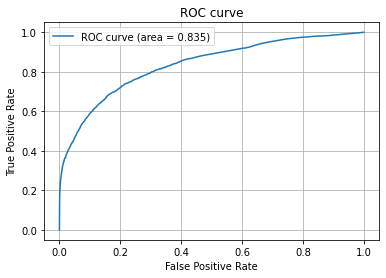

In [52]:
# Plotting for ROC Curve

fpr, tpr, thresholds = metrics.roc_curve(y, y_oof)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

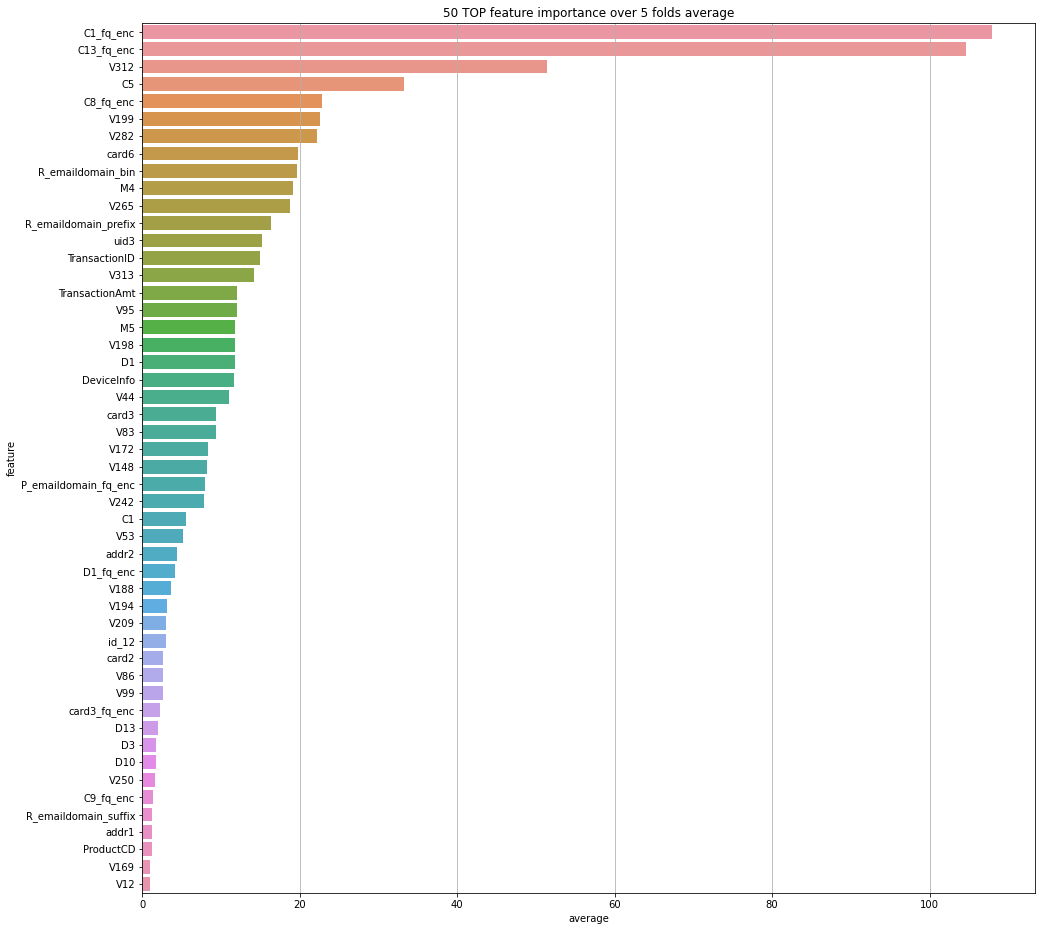

In [55]:
# Plotting feature importance

NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

#### XGBoost



In [88]:
# XGBoost Modeling

X_train = train
X_test = test
y_train = y
xgb_submission=sub.copy()


roc_auc_scores = []
i = 1


y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])

# Using Kfold for this model.
NFOLDS = 5
folds = KFold(n_splits=NFOLDS)




for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train)):
    
    
    xgbclf = xgb.XGBClassifier(
        scale_pos_weight=27.5, # Key feature for handling imbalanced data
        n_estimators=1000,     # Number of trees
        max_depth=9,           # Depth of trees
        learning_rate=0.048,   # Inclement of learning rate
        subsample=0.85,        # Percent of subsamples
        colsample_bytree=0.85, # Number of columns used by each tree
        missing=-999,          # Handling missing values
        tree_method='gpu_hist',# Utilizing GPU
        )
    
    X_train_, X_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    
    xgbclf.fit(X_train_,y_train_)
  
    
    val = xgbclf.predict_proba(X_valid)[:,1]
    pred = xgbclf.predict_proba(X_test)[:,1]
    
    y_pred_valid = xgbclf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
 
    roc_auc = roc_auc_score(y_valid, val)
    roc_auc_scores.append(roc_auc)
    print('AUC in Fold #' + str(i) + ': ' + str(roc_auc))
    i+=1

    gc.collect()
print('Mean AUC: ' + str(np.mean(roc_auc_scores)))
   




AUC in Fold #6: 0.9062808572076182
AUC in Fold #7: 0.9145635417315321
AUC in Fold #8: 0.913767837450814
AUC in Fold #9: 0.9345620973356996
AUC in Fold #10: 0.9143519127045729
Mean AUC: 0.9167052492860475


In [62]:
# Model #2 with StratifiedKfold. It helps with imbalanced data by having same #s of samples

X_train = train
X_test = test
y_train = y
xgb_submission=sub.copy()

roc_auc_scores = []
i = 1



skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)



for fold_n, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
    
    
    xgbclf = xgb.XGBClassifier(
        scale_pos_weight=27.5, # Key feature for handling imbalanced data
        n_estimators=1000,     # Number of trees
        max_depth=9,           # Depth of trees
        learning_rate=0.048,   # Inclement of learning rate
        subsample=0.85,        # Percent of
        colsample_bytree=0.85, # Number of columns used by each tree
        missing=-999,          # Handling missing values
        tree_method='gpu_hist',# Utilizing GPU
        )
    
    X_train_, X_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    
    xgbclf.fit(X_train_,y_train_)
  
    
    val = xgbclf.predict_proba(X_valid)[:,1]
    pred = xgbclf.predict_proba(X_test)[:,1]
    
 
    
    roc_auc = roc_auc_score(y_valid, val)
    roc_auc_scores.append(roc_auc)
    print('AUC in Fold #' + str(i) + ': ' + str(roc_auc))
    i+=1

    gc.collect()
print('Mean AUC: ' + str(np.mean(roc_auc_scores)))
    
    

   


AUC in Fold #0: 0.8452237662625736
AUC in Fold #1: 0.7382471828701764
AUC in Fold #2: 0.7907389817202708
AUC in Fold #3: 0.9092276254120571
AUC in Fold #4: 0.9136500861596488
Mean AUC: 0.8394175284849453


As a result of Stratified Kfold, ROC AUC score went down by 8% or so.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

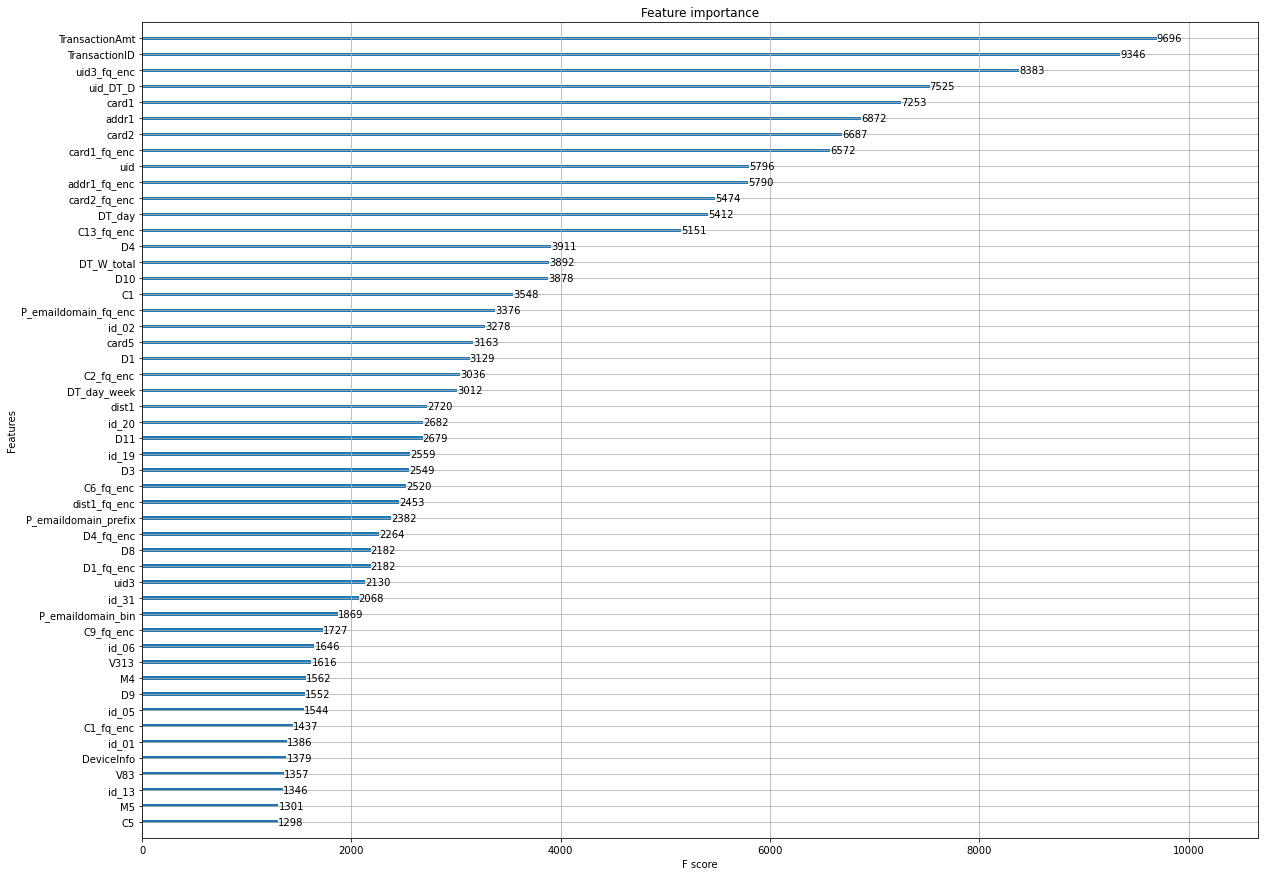

In [75]:
# Plotting featuer imnportance
fig, ax = plt.subplots(1,1,figsize=(20,15)) 
xgb.plot_importance(xgbclf, max_num_features=50, ax=ax)  

#### Catboost

In [76]:
# Data is unbalanced, hence we should initialize class weights

class_weights = [1, y.value_counts()[0]/y.value_counts()[1]]
print(class_weights)

[1, 27.579586700866283]


In [82]:
cb = CatBoostClassifier(eval_metric='AUC',              # Eval matric
                        class_weights=class_weights,    # Handling data imbalance
                        n_estimators=1500,              # Number of trees
                        random_seed=42,                 # Randomizing 
                        task_type="GPU",                # Using GPU instead of CPU
                        silent=True)                    

In [80]:
# Catboost modeling with Kfold cross validation

roc_auc_scores = []
i = 1

NFOLDS = 5
folds = KFold(n_splits=NFOLDS)




for fold_n, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
    
    X_train_, X_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    cb.fit(X_train, y_train)
    
    
    val = cb.predict_proba(X_valid)[:,1]
    pred = cb.predict_proba(X_test)[:,1]
    
    
    roc_auc = roc_auc_score(y_valid, val)
    roc_auc_scores.append(roc_auc)
    print('AUC in Fold #' + str(i) + ': ' + str(roc_auc))
    i+=1
print('Mean AUC: ' + str(np.mean(roc_auc_scores)))

AUC in Fold #1: 0.9941214951351658
AUC in Fold #2: 0.9919367737172772
AUC in Fold #3: 0.9905091589704829
AUC in Fold #4: 0.9920912102934947
AUC in Fold #5: 0.993242733508729
Mean AUC: 0.9923802743250298


In [83]:
# Catboost modeling with StratifiedKfold cross vaildation

roc_auc_scores = []
i = 1

skf = StratifiedKFold(n_splits=5)



for fold_n, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):

    
    X_train_, X_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    cb.fit(X_train, y_train)
    
    
    val = cb.predict_proba(X_valid)[:,1]
    pred = cb.predict_proba(X_test)[:,1]
    
    
    roc_auc = roc_auc_score(y_valid, val)
    roc_auc_scores.append(roc_auc)
    print('AUC in Fold #' + str(i) + ': ' + str(roc_auc))
    i+=1
print('Mean AUC: ' + str(np.mean(roc_auc_scores)))

AUC in Fold #1: 0.948808112767546


AUC in Fold #2: 0.9512651875522647


AUC in Fold #3: 0.943351683312063


AUC in Fold #4: 0.9522888714447304


AUC in Fold #5: 0.9482329308551637
Mean AUC: 0.9487893571863536


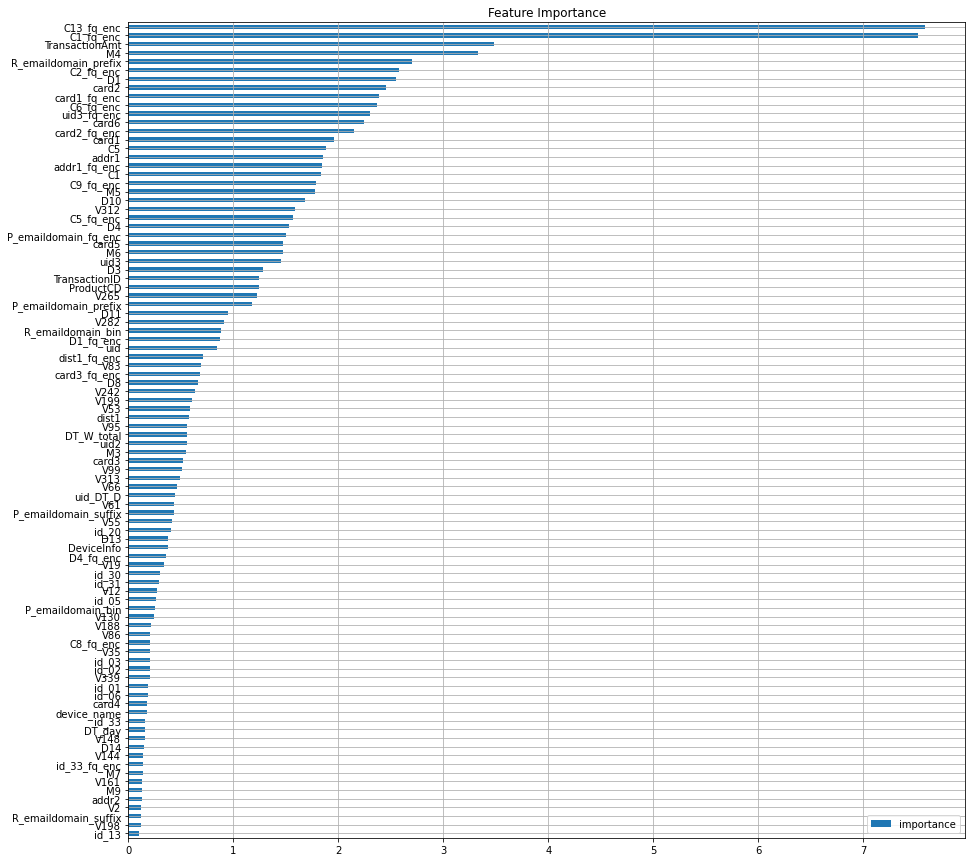

In [84]:
# Feature importance plot
fi = pd.DataFrame(index=cb.feature_names_)
fi['importance'] = cb.feature_importances_
fi.loc[fi['importance'] > 0.1].sort_values('importance').plot(kind='barh', figsize=(15, 15), title='Feature Importance')
plt.show()

## Result

Catboost had best result of 94.9%

1. Catboost: 94.9%
2. Extreme Gradient Boosting: 83.9%
3. Light Grdaient Boosting: 83.5%

## References

1. https://www.kaggle.com/jesucristo/fraud-complete-eda
2. https://www.kaggle.com/mjbahmani/reducing-memory-size-for-ieee
3. https://www.kaggle.com/ysjf13/cis-fraud-detection-visualize-feature-engineering
